# Étape 1 — Chargement et exploration initiale

(116, 10)
   Age        BMI  Glucose  Insulin      HOMA   Leptin  Adiponectin  Resistin  \
0   48  23.500000       70    2.707  0.467409   8.8071     9.702400   7.99585   
1   83  20.690495       92    3.115  0.706897   8.8438     5.429285   4.06405   
2   82  23.124670       91    4.498  1.009651  17.9393    22.432040   9.27715   
3   68  21.367521       77    3.226  0.612725   9.8827     7.169560  12.76600   
4   86  21.111111       92    3.549  0.805386   6.6994     4.819240  10.57635   

     MCP.1  Classification  
0  417.114               1  
1  468.786               1  
2  554.697               1  
3  928.220               1  
4  773.920               1  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116 entries, 0 to 115
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             116 non-null    int64  
 1   BMI             116 non-null    float64
 2   Glucose         116 non-null    int64  

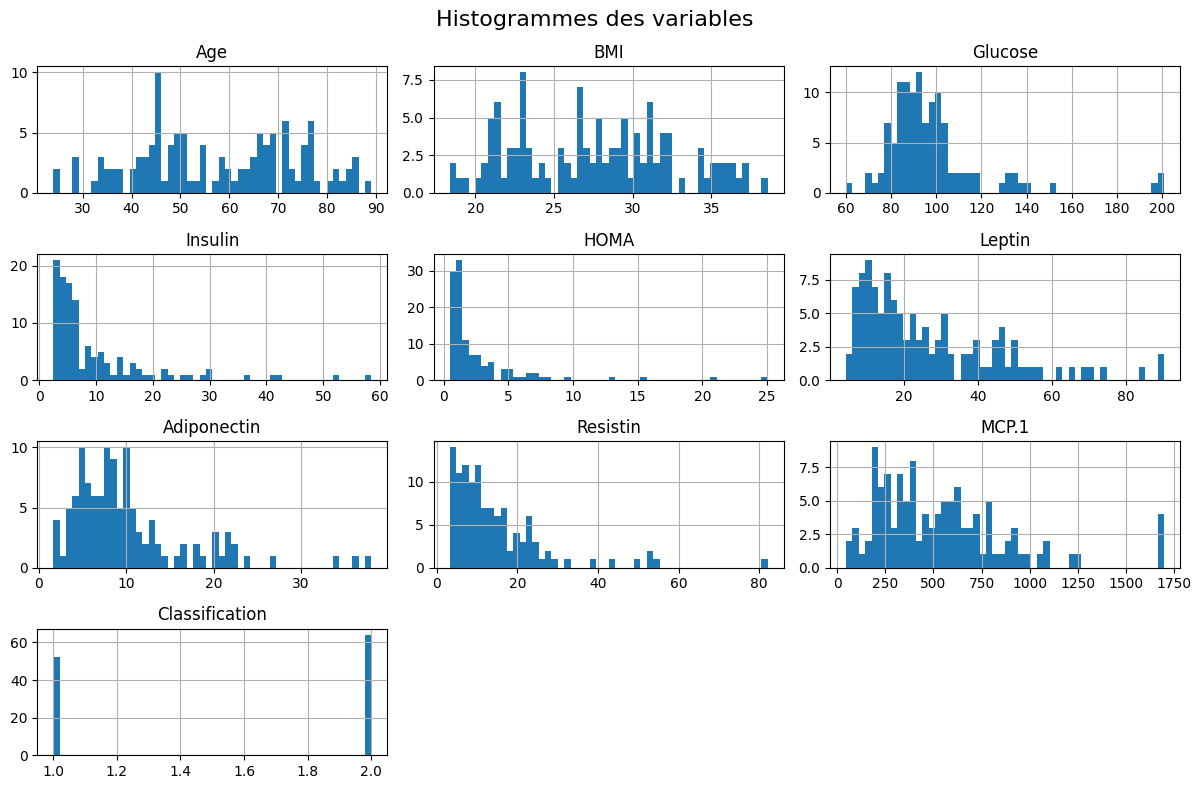

In [1]:
# Import des bibliothèques
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Chargement des données
data = pd.read_csv('breast+cancer+coimbra/dataR2.csv')

# Aperçu des données
print(data.shape)
print(data.head())
data.info()

# Liste des variables explicatives
features = data.columns[:-1]
print("Les variables explicative sont :", list(features))
target = 'Classification'

# Histogrammes des variables
data.hist(bins=50, figsize=(12, 8))
plt.suptitle("Histogrammes des variables", fontsize=16)
plt.tight_layout()
plt.show()


# Étape 2 — Split du dataset en train et test


In [2]:
from sklearn.model_selection import train_test_split
# Séparation des features et de la cible
X = data.drop(columns='Classification')
y = data['Classification'].map({2: 0, 1: 1})
# Mapping : 1 = patient malade (positif), 2 = patient sain (négatif)
# On recode pour avoir : 1 → malade (classe positive), 0 → sain


# Split stratifié pour préserver la distribution des classes
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y)

# Vérification de la forme
print("Train :", X_train.shape, y_train.shape)
print("Test  :", X_test.shape, y_test.shape)


Train : (92, 9) (92,)
Test  : (24, 9) (24,)


# Étape 3 — Visualisation des distributions par classe du dataset d'entrainement

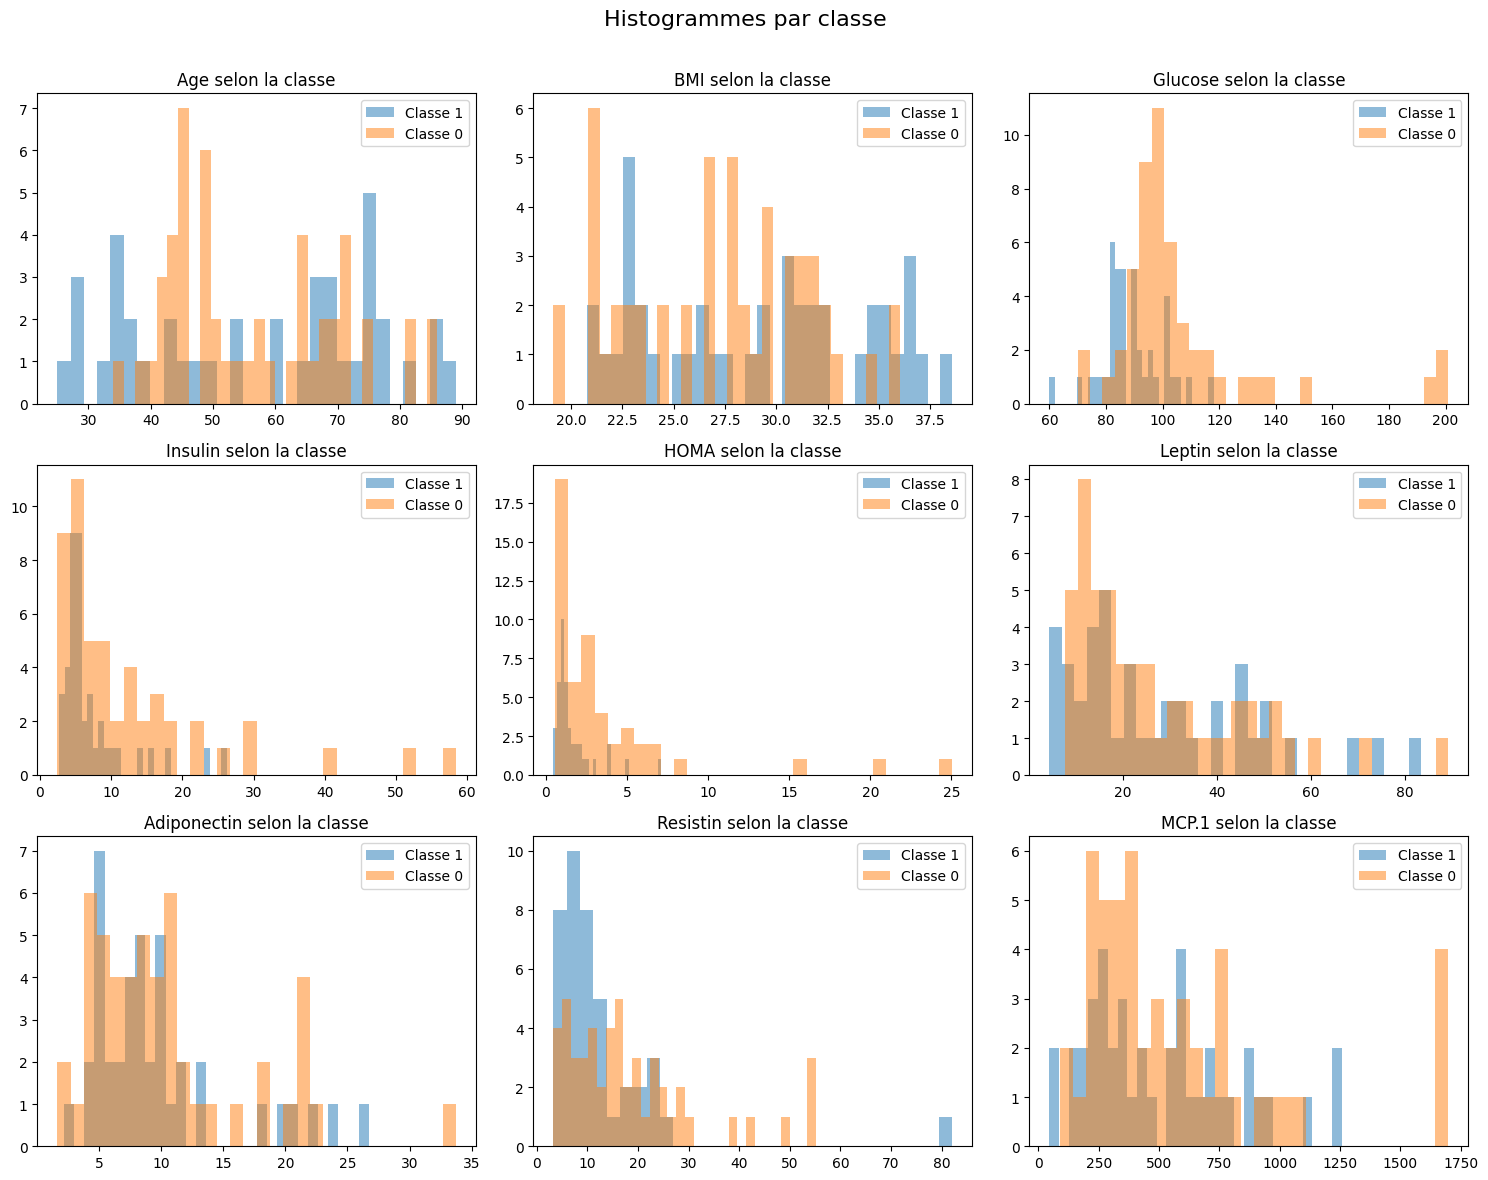

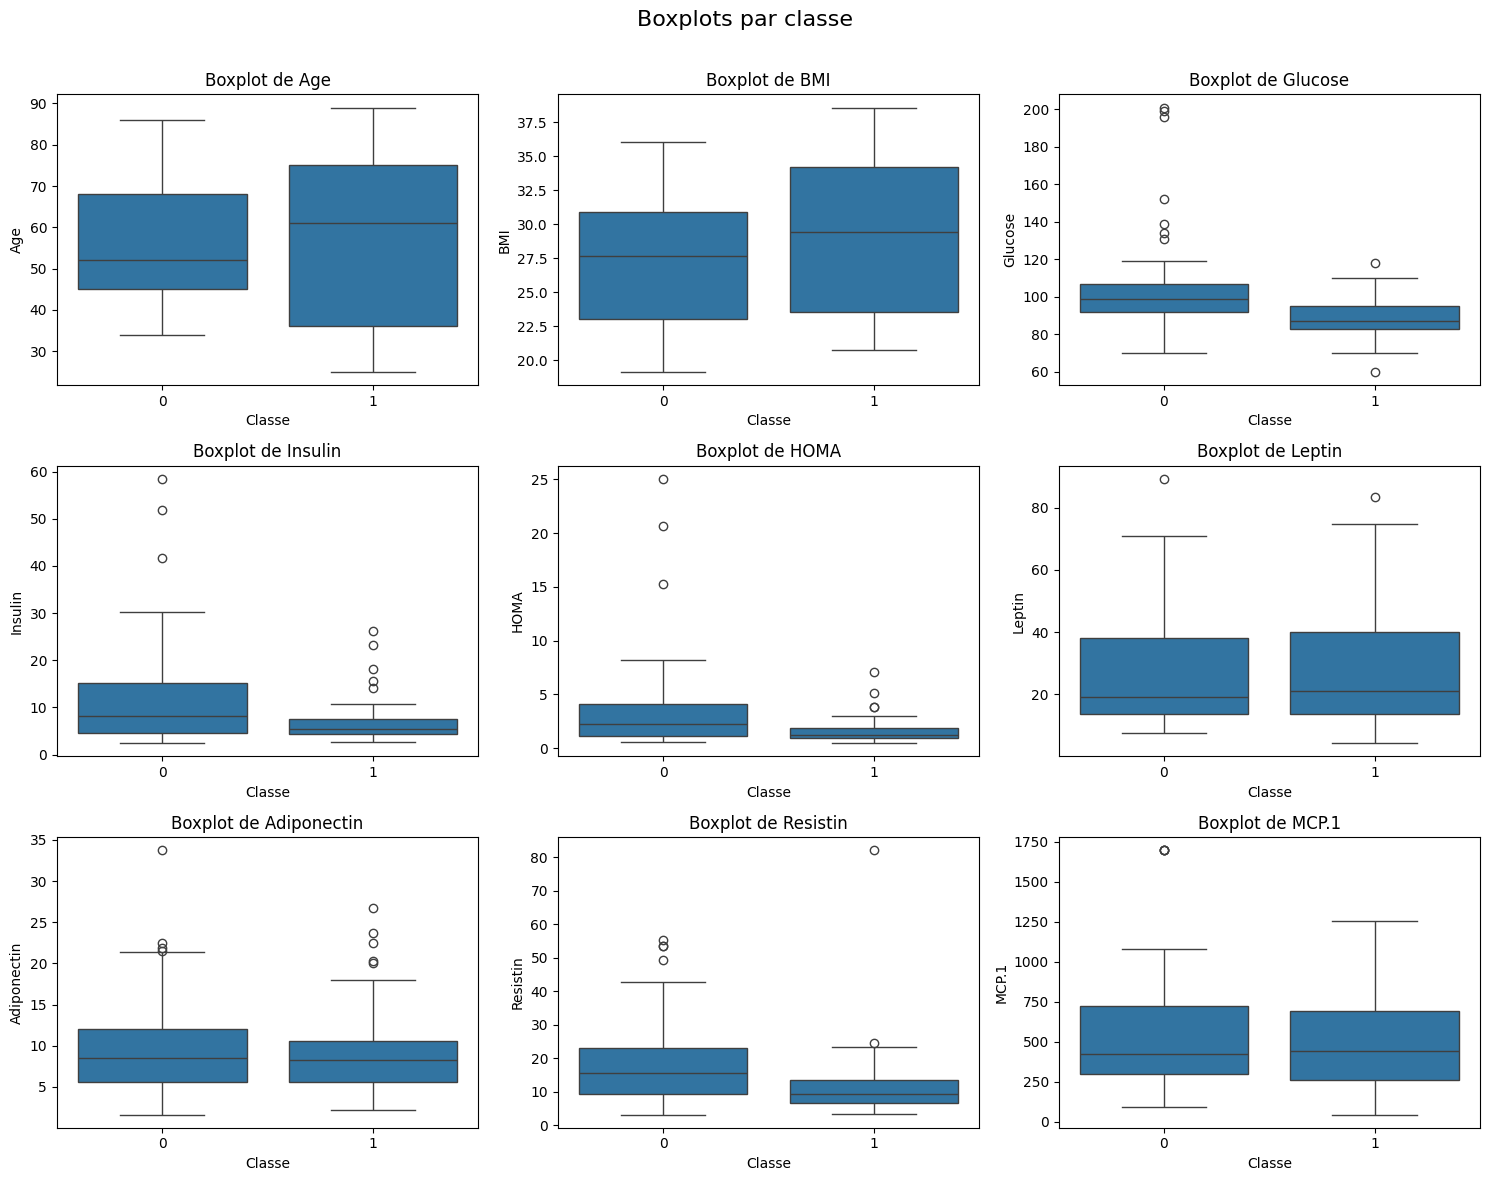

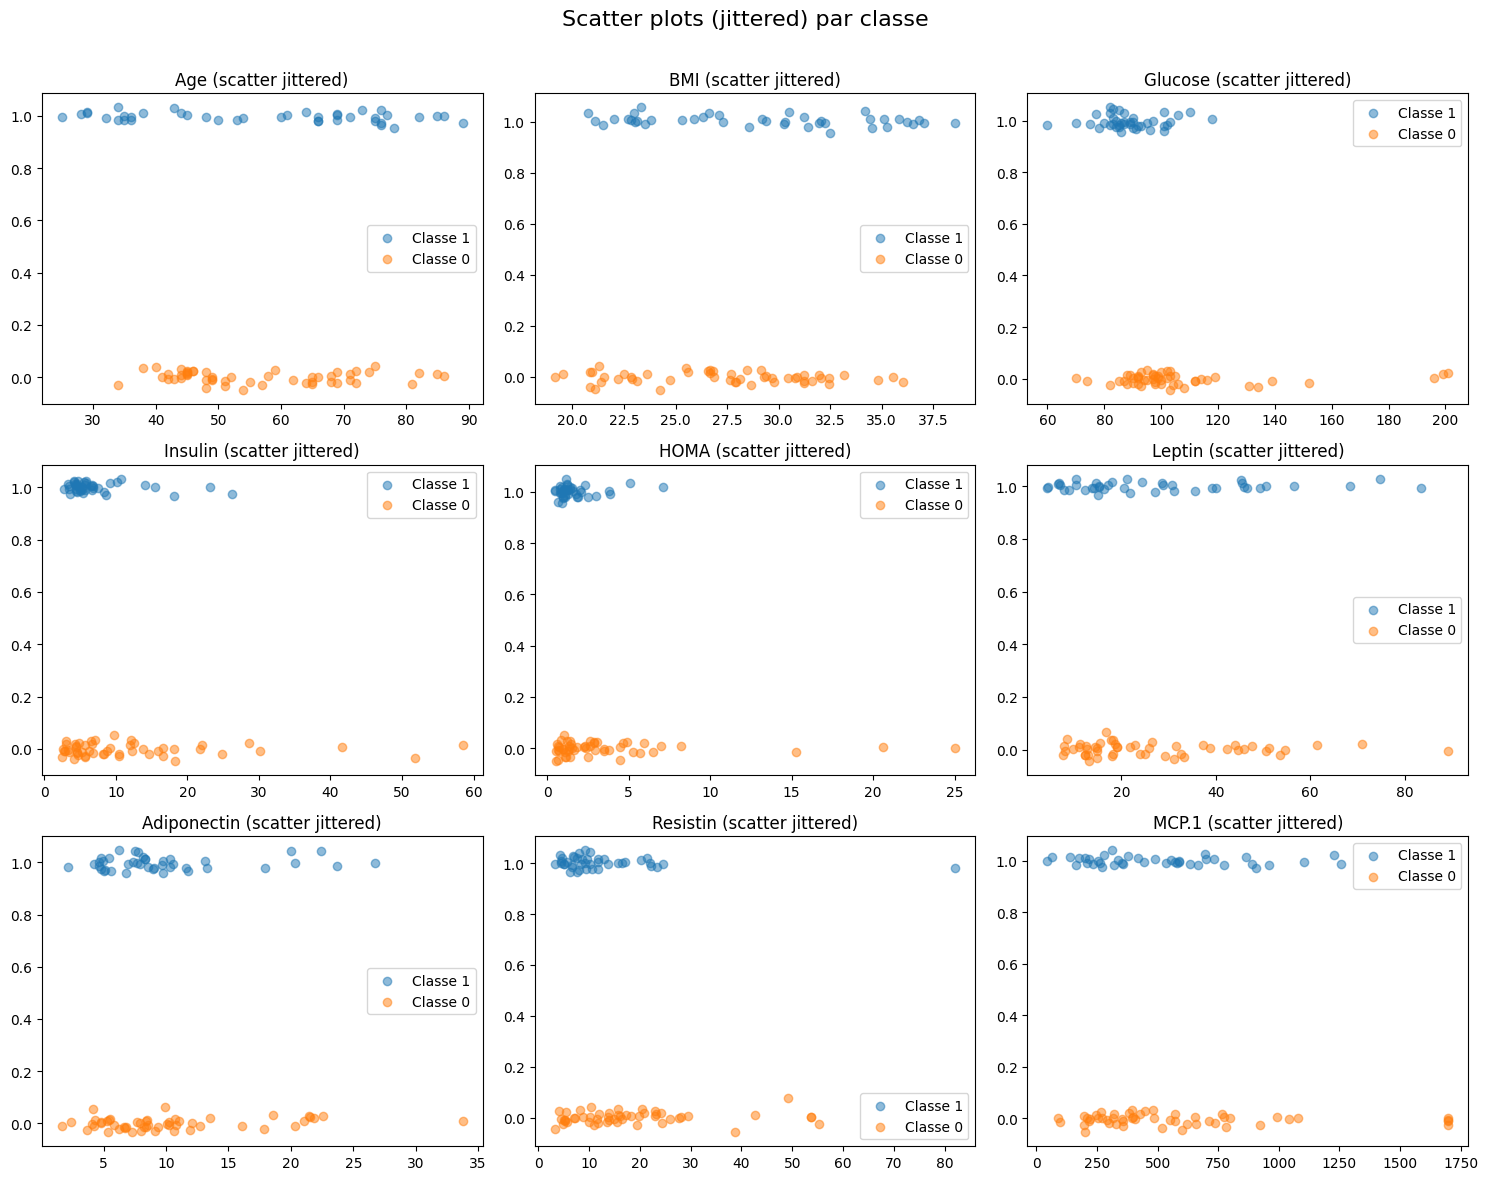

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Fusion temporaire
train_data = X_train.copy()
train_data['Classification'] = y_train

variables = X_train.columns.tolist()
n_cols = 3
n_rows = int(np.ceil(len(variables) / n_cols))

# =======================
# 🔹 1. Tous les histogrammes
# =======================
fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
axes = axes.flatten()

for i, col in enumerate(variables):
    for classe in y_train.unique():
        axes[i].hist(X_train[y_train == classe][col], bins=30, alpha=0.5, label=f"Classe {classe}")
    axes[i].set_title(f"{col} selon la classe")
    axes[i].legend()
    
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

fig.suptitle("Histogrammes par classe", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()


# =======================
# 🔹 2. Tous les boxplots
# =======================
fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
axes = axes.flatten()

for i, col in enumerate(variables):
    sns.boxplot(x=y_train, y=X_train[col], ax=axes[i])
    axes[i].set_title(f"Boxplot de {col}")
    axes[i].set_xlabel("Classe")
    axes[i].set_ylabel(col)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

fig.suptitle("Boxplots par classe", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()


# =======================
# 🔹 3. Tous les scatter (jittered)
# =======================
fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
axes = axes.flatten()

for i, col in enumerate(variables):
    for classe in y_train.unique():
        axes[i].scatter(
            X_train[y_train == classe][col],
            np.random.normal(loc=classe, scale=0.02, size=X_train[y_train == classe][col].shape),
            alpha=0.5,
            label=f"Classe {classe}"
        )
    axes[i].set_title(f"{col} (scatter jittered)")
    axes[i].legend()

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

fig.suptitle("Scatter plots (jittered) par classe", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()


# Étape 4 — Matrice de corrélation et scatter matrix (train uniquement)

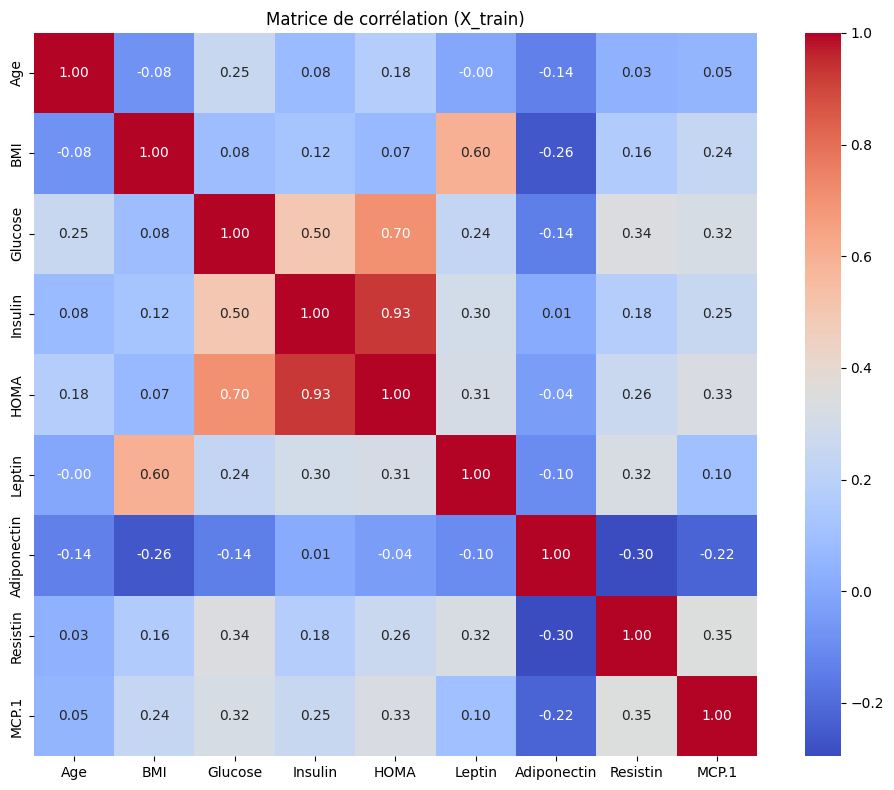

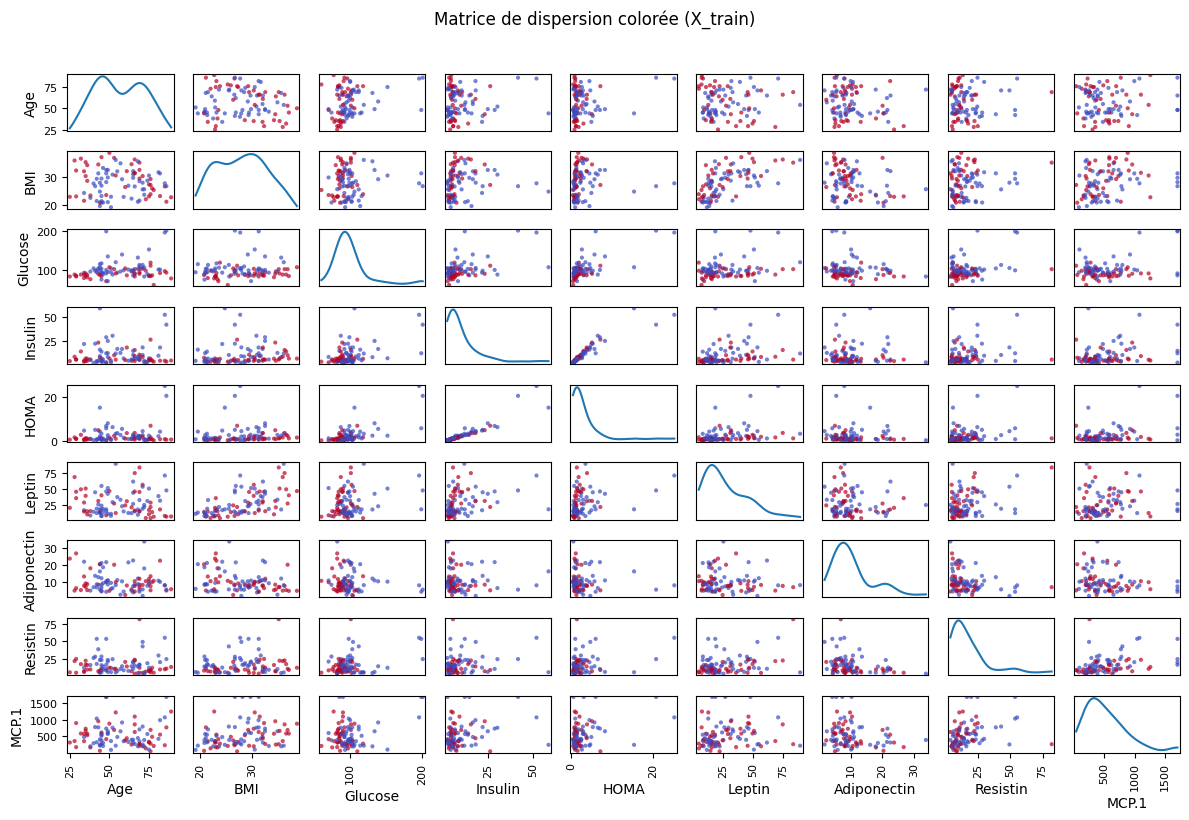

In [4]:
from pandas.plotting import scatter_matrix
# Matrice de corrélation (sur les données d'entraînement)
corr_matrix = X_train.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title("Matrice de corrélation (X_train)")
plt.tight_layout()
plt.show()

# DataFrame combiné pour visualisation colorée
X_train_visu = X_train.copy()
X_train_visu['Classification'] = y_train.values

# Scatter matrix colorée
scatter_matrix(X_train_visu.drop(columns='Classification'),
               figsize=(12, 8),
               diagonal='kde',
               c=X_train_visu['Classification'],
               cmap='coolwarm',
               alpha=0.7)
plt.suptitle("Matrice de dispersion colorée (X_train)", y=1.02)
plt.tight_layout()
plt.show()



# Étape 5 — Transformation logarithmique 

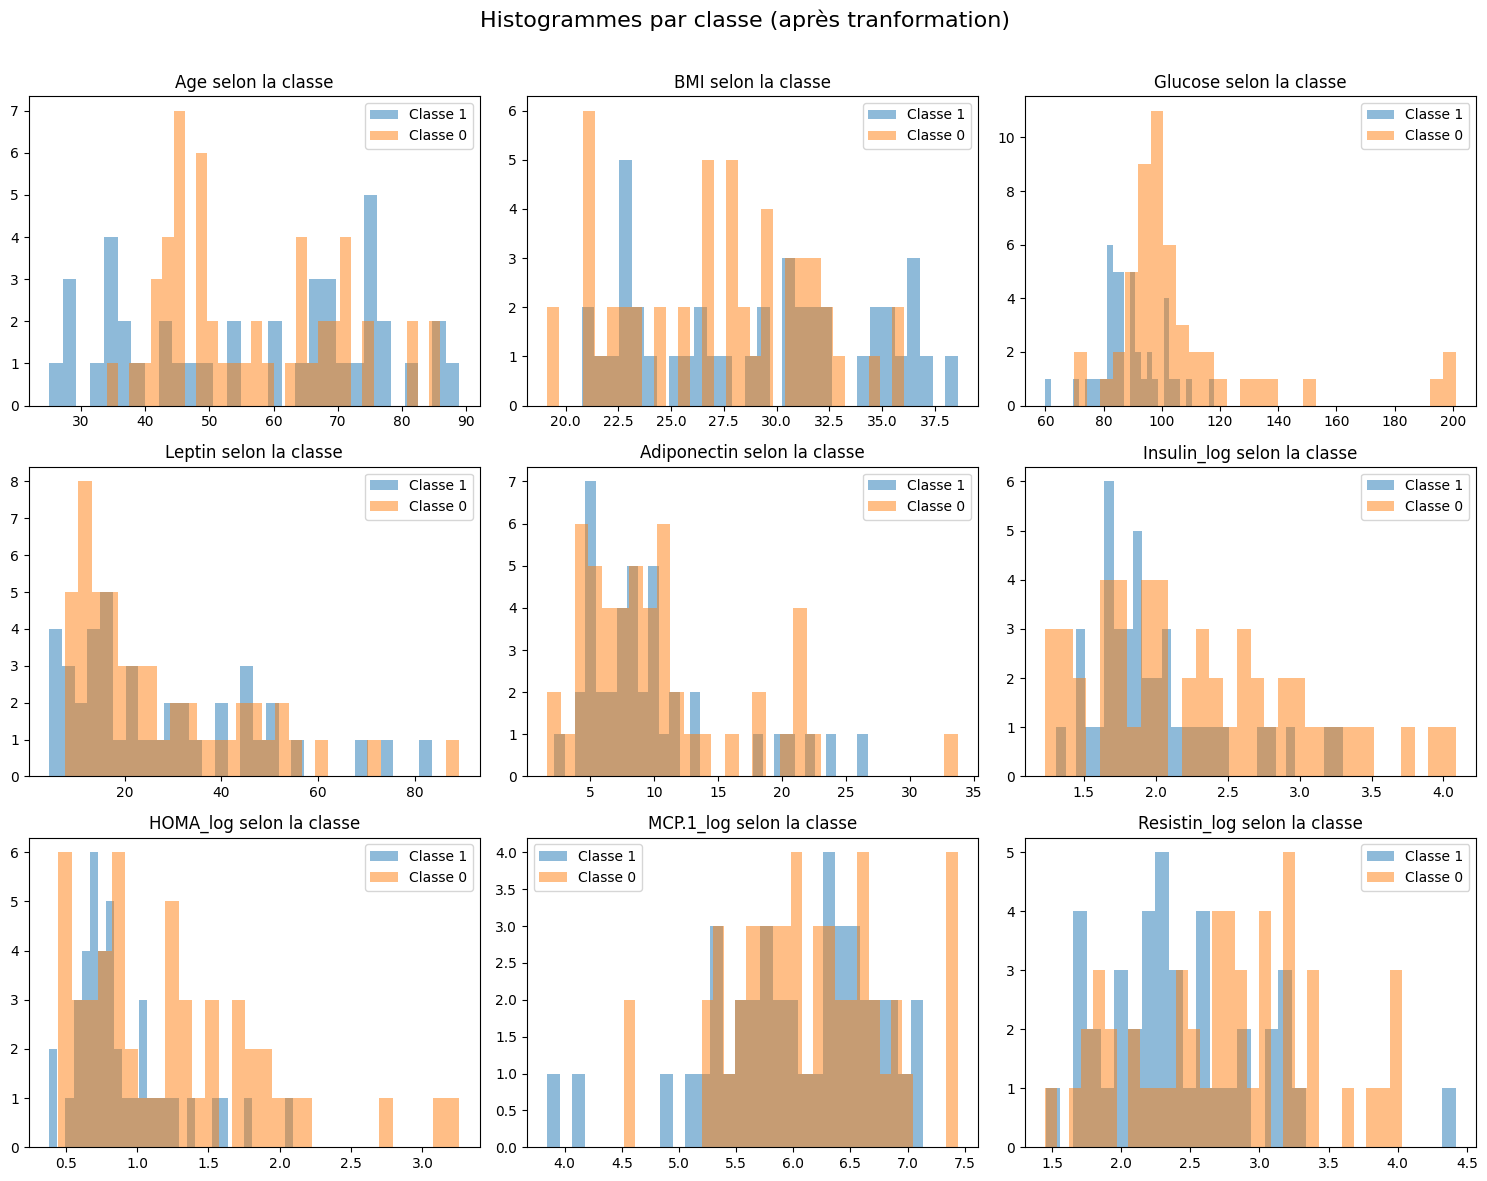

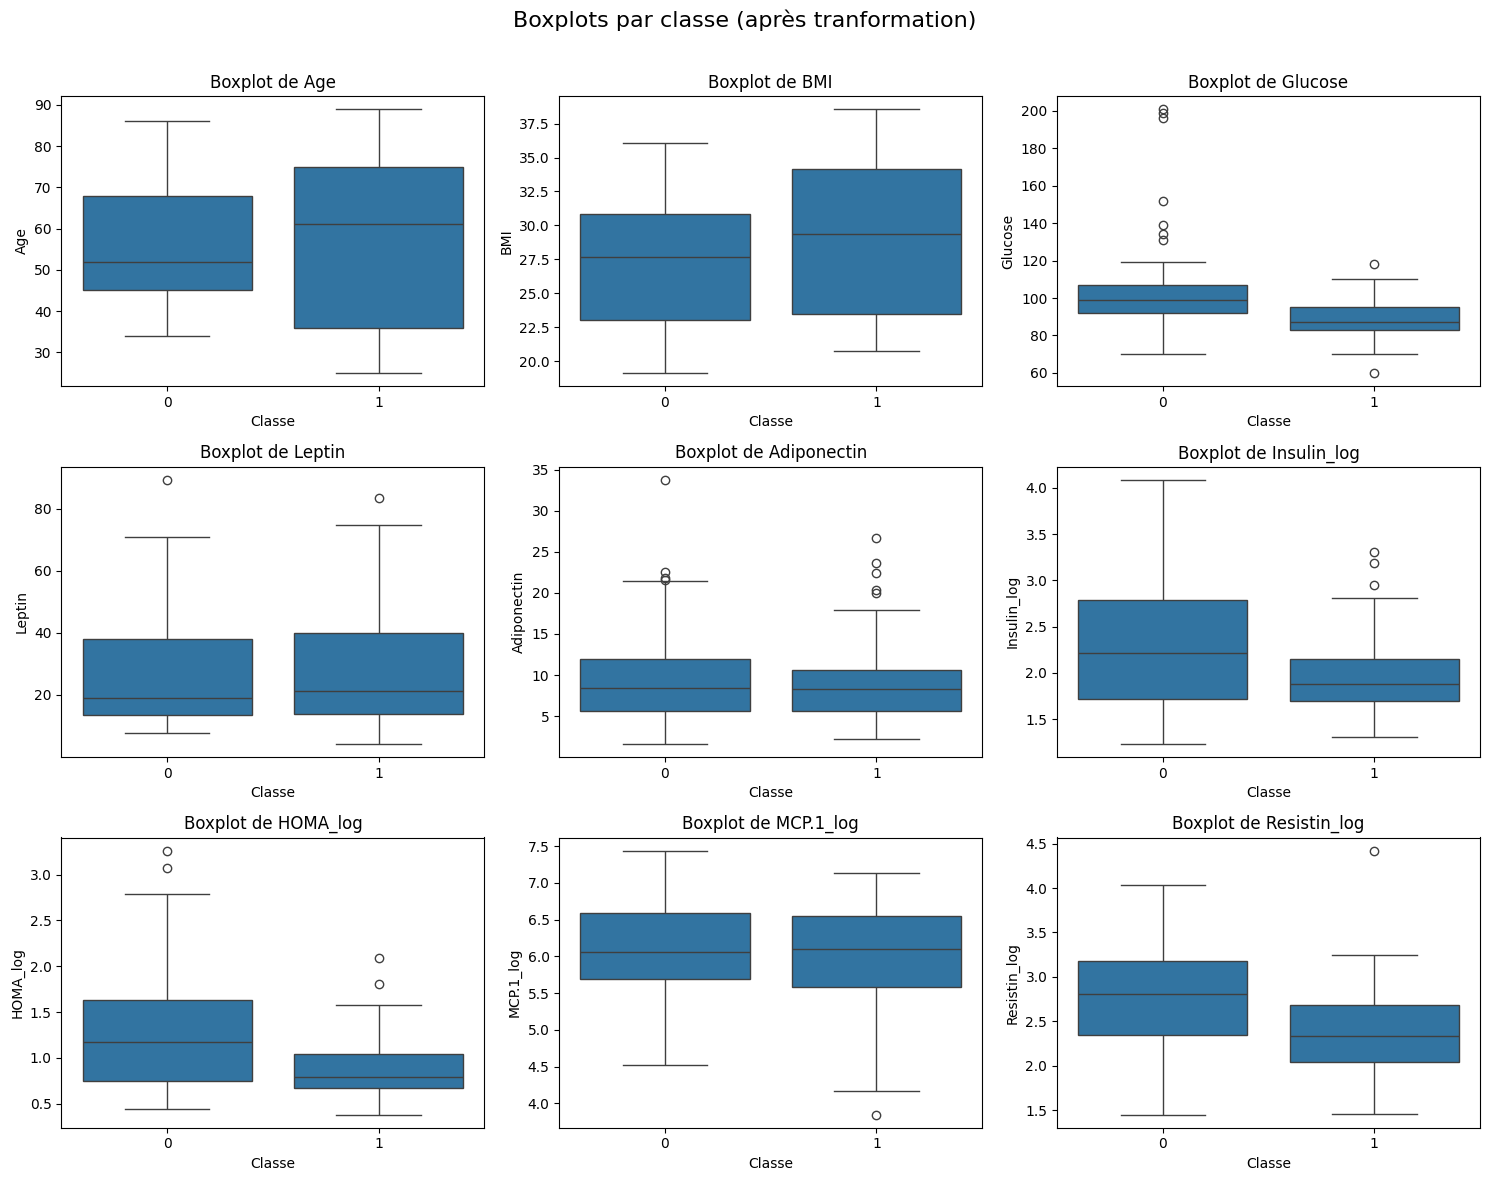

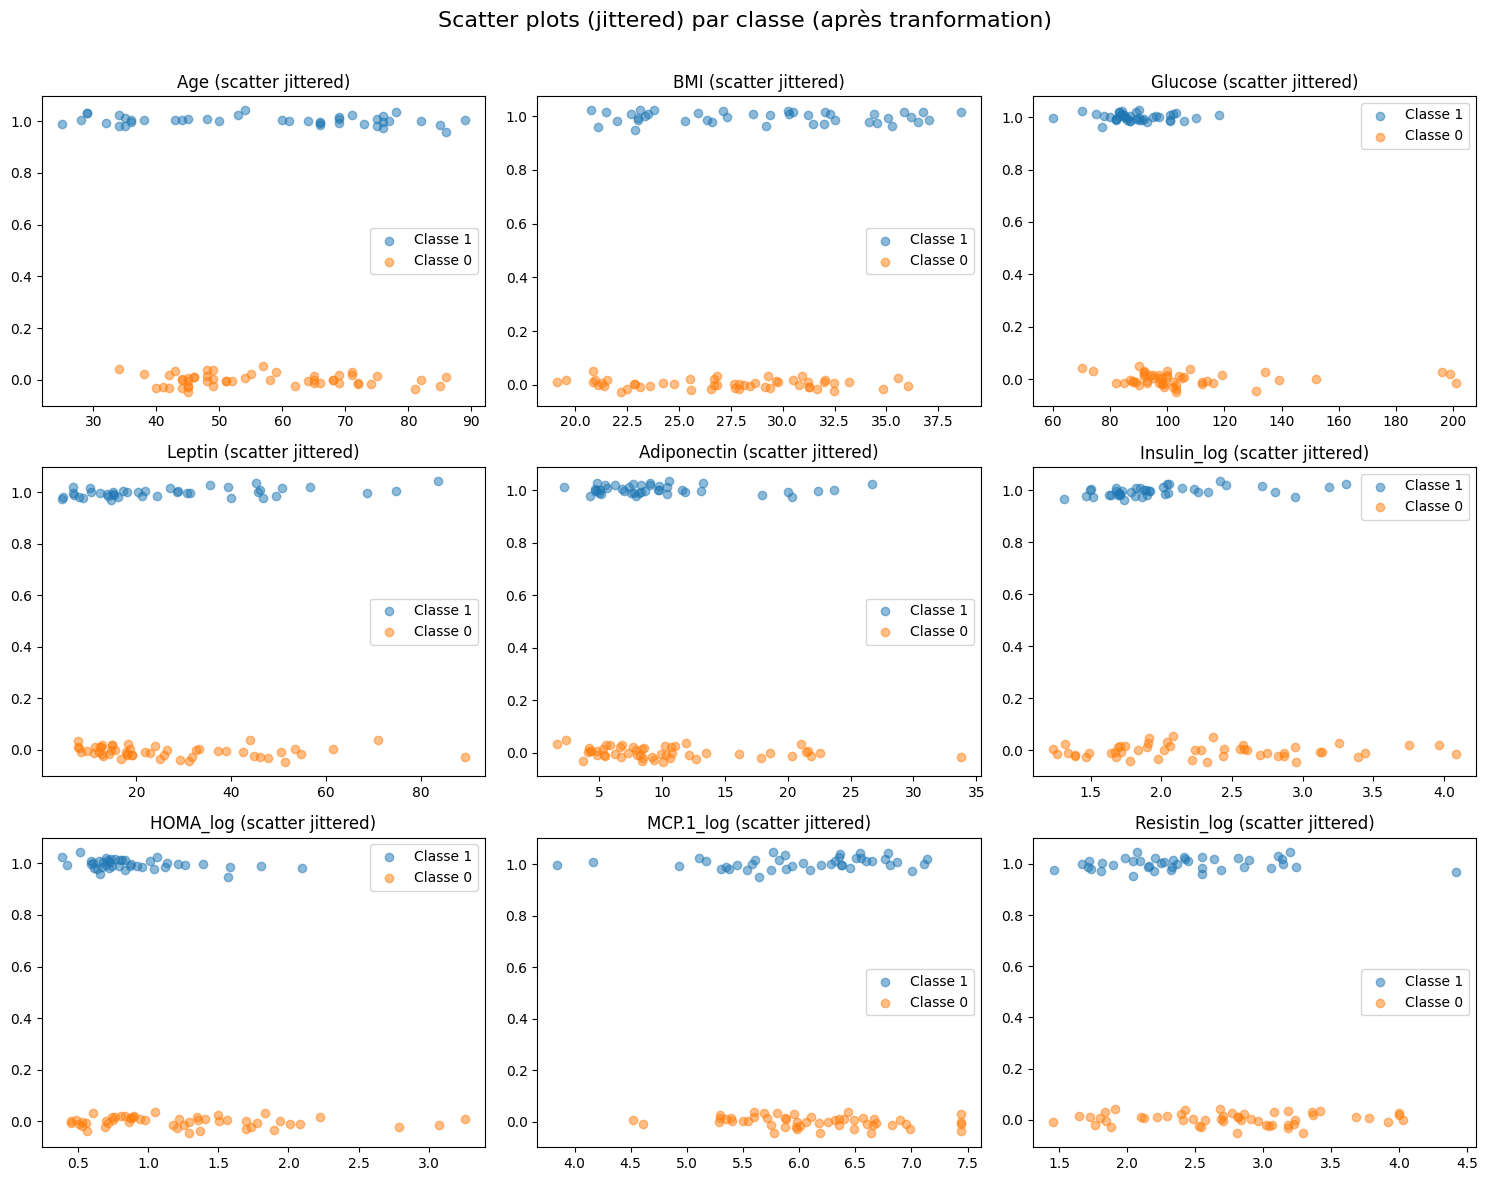

In [5]:
# Variables à transformer (forte asymétrie identifiée précédemment) 
variables_log = ['Insulin', 'HOMA', 'MCP.1', 'Resistin']

# Copie de X_train pour transformation
X_train_transformed = X_train.copy()

# Transformation log(x + 1)
for col in variables_log:
    X_train_transformed[col + '_log'] = np.log1p(X_train_transformed[col])
    
# Suppression des colonnes d'origine (optionnelle mais recommandée)
X_train_transformed = X_train_transformed.drop(columns=variables_log)

# Mise à jour de la liste des variables
features = X_train_transformed.columns.tolist()

# Fusion temporaire pour les visualisations
train_data2 = X_train_transformed.copy()
train_data2['Classification'] = y_train

n_cols = 3
n_rows = int(np.ceil(len(features) / n_cols))

# Histogrammes
fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
axes = axes.flatten()

for i, col in enumerate(features):
    for classe in y_train.unique():
        axes[i].hist(X_train_transformed[y_train == classe][col], bins=30, alpha=0.5, label=f"Classe {classe}")
    axes[i].set_title(f"{col} selon la classe")
    axes[i].legend()
    
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

fig.suptitle("Histogrammes par classe (après tranformation)", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

# Boxplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
axes = axes.flatten()

for i, col in enumerate(features):
    sns.boxplot(x=y_train, y=X_train_transformed[col], ax=axes[i])
    axes[i].set_title(f"Boxplot de {col}")
    axes[i].set_xlabel("Classe")
    axes[i].set_ylabel(col)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

fig.suptitle("Boxplots par classe (après tranformation)", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

# Scatter plots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
axes = axes.flatten()

for i, col in enumerate(features):
    for classe in y_train.unique():
        axes[i].scatter(
            X_train_transformed[y_train == classe][col],
            np.random.normal(loc=classe, scale=0.02, size=X_train_transformed[y_train == classe][col].shape),
            alpha=0.5,
            label=f"Classe {classe}"
        )
    axes[i].set_title(f"{col} (scatter jittered)")
    axes[i].legend()

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

fig.suptitle("Scatter plots (jittered) par classe (après tranformation)", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()


    



# Étape 6 — Standardisation (StandardScaler)

In [6]:
from sklearn.preprocessing import StandardScaler

# Initialisation du scaler
scaler = StandardScaler()

# Entraînement du scaler sur le jeu transformé
X_train_scaled = pd.DataFrame(
    scaler.fit_transform(X_train_transformed),
    columns=X_train_transformed.columns,
    index=X_train_transformed.index
)

X_train_scaled.describe().T[['mean', 'std']]


,mean,std
Age,1.037817e-16,1.005479
BMI,-8.447349e-17,1.005479
Glucose,1.995309e-16,1.005479
Leptin,6.033821e-17,1.005479
Adiponectin,1.436049e-16,1.005479
Insulin_log,2.292852e-16,1.005479
HOMA_log,-3.891814e-16,1.005479
MCP.1_log,-7.406515e-16,1.005479
Resistin_log,-1.680419e-16,1.005479


# Étape 7 — Préparation de X_test

In [7]:
# Copie de X_test
X_test_transformed = X_test.copy()

# Appliquer les mêmes log-transforms
for col in variables_log:
    X_test_transformed[col + '_log'] = np.log1p(X_test_transformed[col])

# Supprimer les colonnes originales
X_test_transformed = X_test_transformed.drop(columns=variables_log)

# Standardiser avec le scaler déjà entraîné sur X_train
X_test_scaled = pd.DataFrame(
    scaler.transform(X_test_transformed),
    columns=X_test_transformed.columns,
    index=X_test_transformed.index
)

# Vérifie que les colonnes de X_test sont identiques (et dans le même ordre) à celles de X_train, pour éviter des erreurs de prédiction
if list(X_train_scaled.columns) != list(X_test_scaled.columns):
    print( "Mismatch between train and test columns")


# Étape 8 — Modélisation avec SVM (rbf)

Accuracy : 0.75
F1-score : 0.727

Classification report :
              precision    recall  f1-score   support

           0       0.77      0.77      0.77        13
           1       0.73      0.73      0.73        11

    accuracy                           0.75        24
   macro avg       0.75      0.75      0.75        24
weighted avg       0.75      0.75      0.75        24



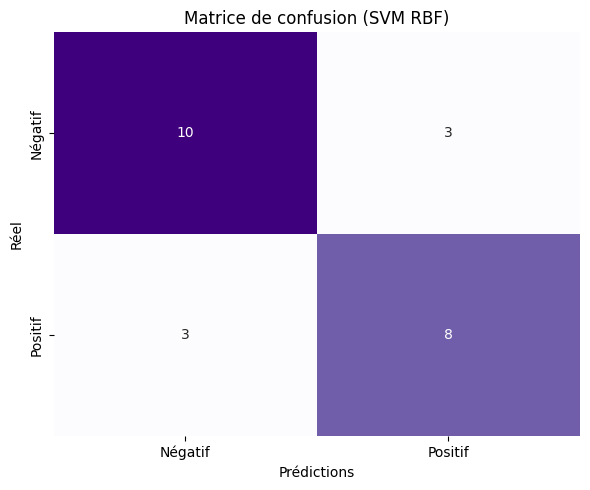

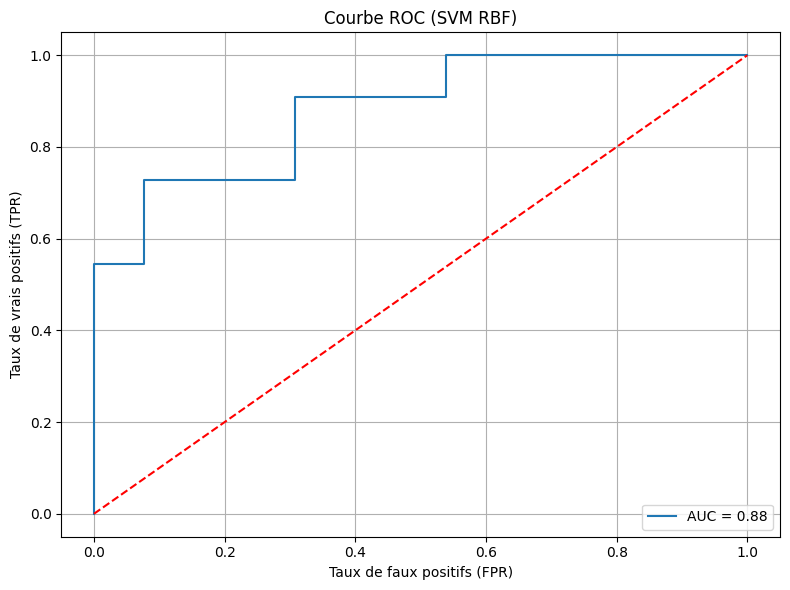

In [8]:

from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, roc_curve, auc

# Initialisation du modèle
svm_rbf = SVC(kernel='rbf', C=1.0, gamma='scale', probability=True, random_state=42)

# Entraînement
svm_rbf.fit(X_train_scaled, y_train)

# Prédiction
y_pred_svm = svm_rbf.predict(X_test_scaled)
y_proba_svm = svm_rbf.predict_proba(X_test_scaled)[:, 1]

# Évaluation
# Accuracy & F1
print("Accuracy :", round(accuracy_score(y_test, y_pred_svm), 3))
print("F1-score :", round(f1_score(y_test, y_pred_svm), 3))

# Rapport de classification
print("\nClassification report :")
print(classification_report(y_test, y_pred_svm))

# Matrice de confusion
cm = confusion_matrix(y_test, y_pred_svm)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples', cbar=False,
            xticklabels=['Négatif', 'Positif'], yticklabels=['Négatif', 'Positif'])
plt.title("Matrice de confusion (SVM RBF)")
plt.xlabel("Prédictions")
plt.ylabel("Réel")
plt.tight_layout()
plt.show()

# Courbe ROC
fpr, tpr, _ = roc_curve(y_test, y_proba_svm)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='red')
plt.title("Courbe ROC (SVM RBF)")
plt.xlabel("Taux de faux positifs (FPR)")
plt.ylabel("Taux de vrais positifs (TPR)")
plt.legend(loc="lower right")
plt.grid()
plt.tight_layout()
plt.show()



# Recherche d'hyperparamètres (C et gamma)

In [9]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

# Définition de la grille des hyperparamètres
param_grid_svm = {
    'C': [0.01, 0.1, 1, 10, 100],
    'gamma': ['scale', 0.001, 0.01, 0.1, 1],
    'kernel': ['rbf']
}

# Initialisation du modèle
svm = SVC(probability=True, random_state=42)

# GridSearch avec validation croisée 10 folds
grid_search_svm = GridSearchCV(
    svm,
    param_grid=param_grid_svm,
    scoring='f1',
    cv=10,
    n_jobs=-1
)

# Entraînement
grid_search_svm.fit(X_train_scaled, y_train)

# Meilleur modèle trouvé
best_svm = grid_search_svm.best_estimator_

# Résultats
print("Meilleurs hyperparamètres :", grid_search_svm.best_params_)
print("F1-score moyen sur CV :", round(grid_search_svm.best_score_, 3))


Meilleurs hyperparamètres : {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}
F1-score moyen sur CV : 0.734


Accuracy : 0.75
F1-score : 0.75

Classification report :
              precision    recall  f1-score   support

           0       0.82      0.69      0.75        13
           1       0.69      0.82      0.75        11

    accuracy                           0.75        24
   macro avg       0.76      0.76      0.75        24
weighted avg       0.76      0.75      0.75        24



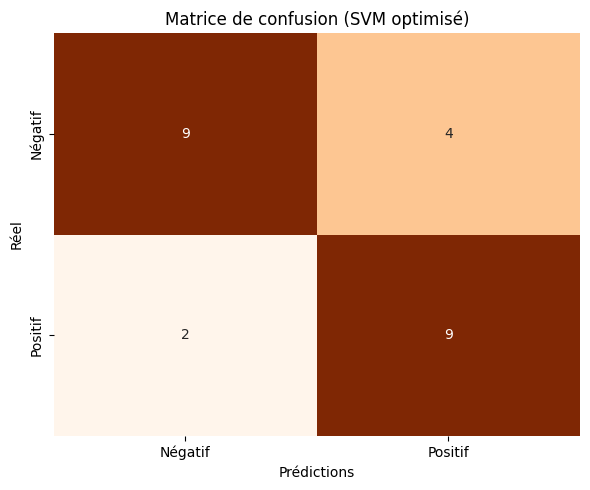

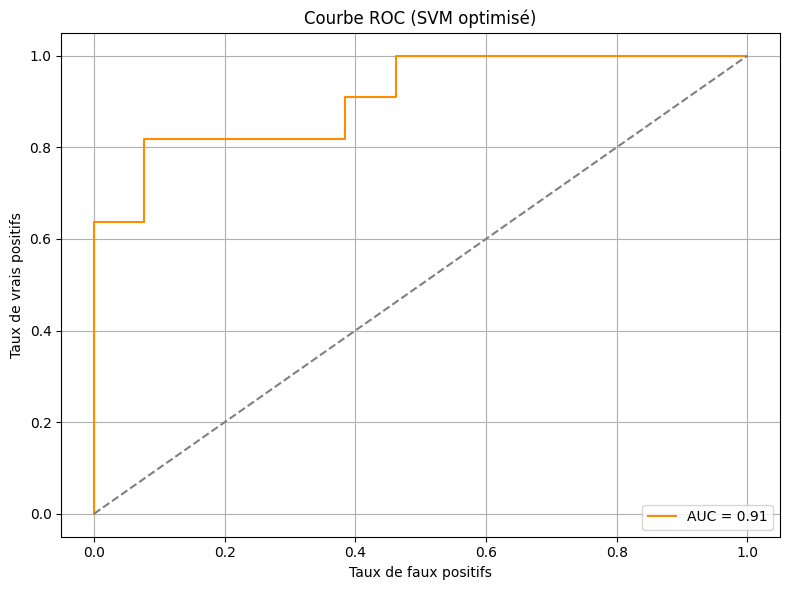

In [10]:
# Prédictions
y_pred_best_svm = best_svm.predict(X_test_scaled)
y_proba_best_svm = best_svm.predict_proba(X_test_scaled)[:, 1]

# Scores
print("Accuracy :", round(accuracy_score(y_test, y_pred_best_svm), 3))
print("F1-score :", round(f1_score(y_test, y_pred_best_svm), 3))
print("\nClassification report :")
print(classification_report(y_test, y_pred_best_svm))

# Matrice de confusion
cm = confusion_matrix(y_test, y_pred_best_svm)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges', cbar=False,
            xticklabels=['Négatif', 'Positif'], yticklabels=['Négatif', 'Positif'])
plt.title("Matrice de confusion (SVM optimisé)")
plt.xlabel("Prédictions")
plt.ylabel("Réel")
plt.tight_layout()
plt.show()

# Courbe ROC
fpr, tpr, _ = roc_curve(y_test, y_proba_best_svm)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}", color='darkorange')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.title("Courbe ROC (SVM optimisé)")
plt.xlabel("Taux de faux positifs")
plt.ylabel("Taux de vrais positifs")
plt.legend(loc="lower right")
plt.grid()
plt.tight_layout()
plt.show()


SVM linéaire - Accuracy : 0.75
SVM linéaire - F1-score : 0.75

Classification Report :
              precision    recall  f1-score   support

           0       0.82      0.69      0.75        13
           1       0.69      0.82      0.75        11

    accuracy                           0.75        24
   macro avg       0.76      0.76      0.75        24
weighted avg       0.76      0.75      0.75        24



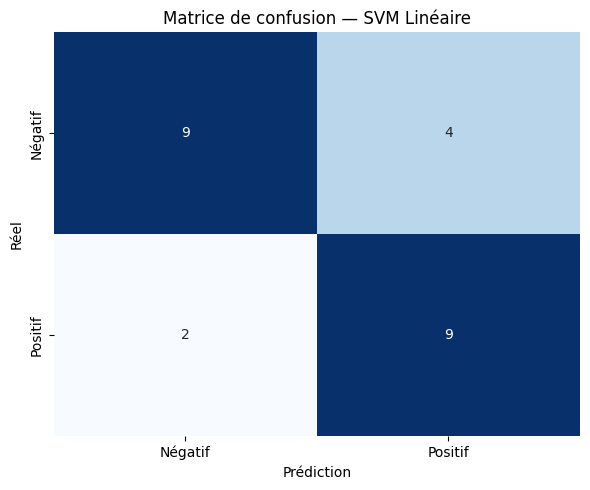

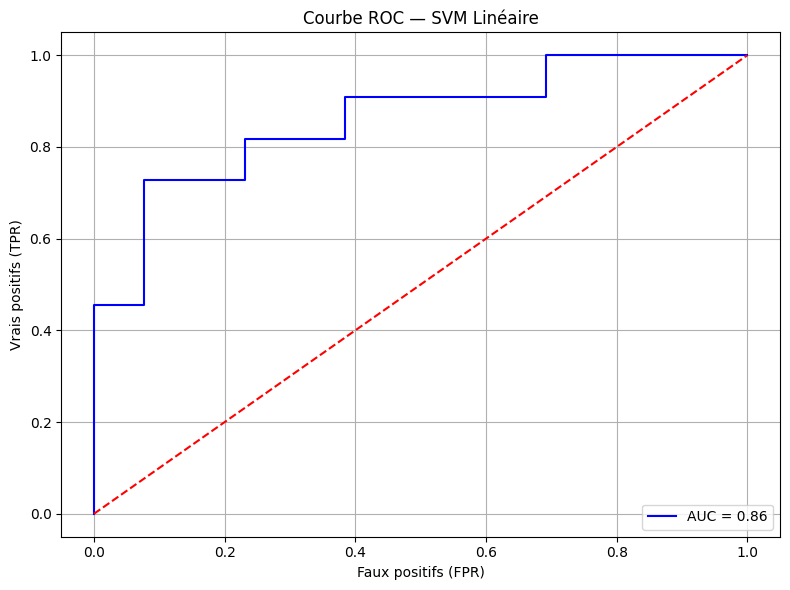

In [11]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Initialisation du modèle SVM linéaire
svm_linear = SVC(kernel='linear', probability=True, random_state=42)

# 2. Entraînement sur le jeu d'entraînement
svm_linear.fit(X_train_scaled, y_train)

# 3. Prédictions
y_pred_svm_lin = svm_linear.predict(X_test_scaled)
y_proba_svm_lin = svm_linear.predict_proba(X_test_scaled)[:, 1]

# 4. Évaluation
acc_lin = accuracy_score(y_test, y_pred_svm_lin)
f1_lin = f1_score(y_test, y_pred_svm_lin)
print("SVM linéaire - Accuracy :", round(acc_lin, 3))
print("SVM linéaire - F1-score :", round(f1_lin, 3))
print("\nClassification Report :")
print(classification_report(y_test, y_pred_svm_lin))

# 5. Matrice de confusion
cm = confusion_matrix(y_test, y_pred_svm_lin)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Négatif', 'Positif'],
            yticklabels=['Négatif', 'Positif'])
plt.title("Matrice de confusion — SVM Linéaire")
plt.xlabel("Prédiction")
plt.ylabel("Réel")
plt.tight_layout()
plt.show()

# 6. Courbe ROC
fpr, tpr, thresholds = roc_curve(y_test, y_proba_svm_lin)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='red')
plt.title('Courbe ROC — SVM Linéaire')
plt.xlabel('Faux positifs (FPR)')
plt.ylabel('Vrais positifs (TPR)')
plt.grid()
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()
